# Binary segmentation with Markov random fields and belief propagation

A common task in image processing is the segmentation of images into a given number of phases. Several information from the image can be used for such a segmentation. First, similar gray-level values are more likely to belong to the same phase; second, neighboring pixels are more likely to belong to the same phase, if your image consists of distinct objects and not of random pixel values. A large class of method exists that leverages these two kinds of information. Here, I will focus on two methods: **graph cuts** optimization, that is a very classical methods in image processing and computer vision, and **belief propagation**, that is perhaps less known to a general audience but is also very interesting. 

Let us start by defining a binary image.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

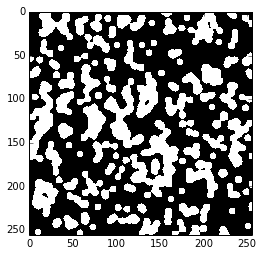

In [4]:
from skimage import filters
def generate_synthetic_data(l_x=128, seed=None, n_pts=25, ndim=2):
    """
    Generates synthetic binary data with blob-like objects.
    """
    rs = np.random.RandomState(seed)
    x, y = np.ogrid[:l_x, :l_x]
    mask = np.zeros((l_x, l_x))
    points = l_x * rs.rand(2, n_pts)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = filters.gaussian_filter(mask, sigma=l_x / (4. * np.sqrt(n_pts)))
    mask = mask > mask.mean()
    return mask.astype(np.float)

im = generate_synthetic_data(l_x=256, n_pts=500)
im -= 0.5
im *= 2

plt.imshow(im, cmap='gray', interpolation='nearest')

The image ``im`` is completely binary, but let us suppose that it is corrupted with Gaussian noise. We can do this very easily with NumPy.

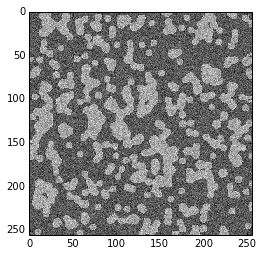

In [13]:
noisy_im = im + 0.6 * np.random.randn(*im.shape)
plt.imshow(noisy_im, cmap='gray', interpolation='nearest')

Although the contrast is not as good as in the original image, we can still distinguish quite well different grey levels. What if we try to binarize the image using just pixel values, and trying to classify them into two families? ``scikit-image`` provides a function for automatic thresholding and binarization, using Otsu's method.

Otsu threshold: -0.030895
Fraction of errors: 0.048096


<matplotlib.contour.QuadContourSet instance at 0x7f2576762b48>

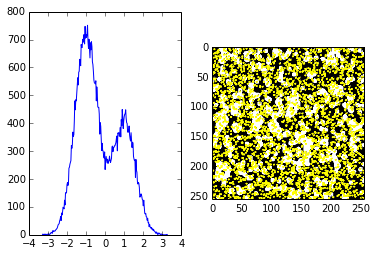

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2)

from skimage import exposure
hi = exposure.histogram(noisy_im)
ax1.plot(hi[1], hi[0])

threshold = filters.threshold_otsu(noisy_im)
print("Otsu threshold: %f" %threshold)
binary_otsu = noisy_im > threshold
errors = np.logical_not(binary_otsu == (im > 0))
segmentation_score = errors.mean()
print("Fraction of errors: %f" %segmentation_score)

ax2.imshow(binary_otsu, cmap='gray')
ax2.contour(errors, colors='yellow')

So, the result is not so bad, but we still get a fraction of the order of 5% pixels that are wrongly attributed. As we can see from the histogram, the two peaks are not so well separated: no wonder that a segmentation based only on pixel values results in some errors. 

Can we dot better is use spatial information about pixels as well? Our eye does it very well, by smoothing together neighboring pixels, so that we can distinguish objects very well despite the presence of noise. A first idea would be to perform a first **denoising** step on the image, by using a filter that averages the value of a pixel with other values of pixels, often neighbors of the pixels. Filtering is a way to make use of the spatial information. Different denoising filters are available in ``scikit-image``, such as median filter, bilateral filter, total-variation denoising, etc. See for example http://scikit-image.org/docs/dev/auto_examples/plot_denoise.html for a comparison of different denoising filters. Denoising will typicall sharpen histogram peaks, so that Otsu thresholding is more accurate on a denoised image. Here, we will employ a different strategy, by trying to use at the same time information on gray values and on spatial proximity, and perform the segmentation in one step.

A classical way to consider this problem is to consider the looked-for solution as a set of random binary variable, and to define a cost function, or energy, associated to realizations of the binary variables. The energy should have two terms: one that favors that pixels have the same sign as in the experimental noisy image, and another term that will penalize neighboring pixels with opposite signs. If we call $x_i$ the value of pixel $i$ in the noisy image, and $s_i$ the binary value that we're looking for, the energy can be defined as
$$E(\{s_i\}) = \sum_i (x_i - s_i)^2 - J \sum_{<i,j>} s_i s_j$$
Since $s_i^2 = 1$ and $x_i$ is a constant, it is equivalent to use the energy
$$E(\{s_i\}) = - \sum_i 2 x_i s_i - J \sum_{<i,j>} s_i s_j$$

This energy model is known as Ising model in statistical physics (with the $x_i$ from the noisy image corresponding to a frozen external magnetic field, and the $s_i$ being called *spins*), or it's also a common example of *Markov random field*.

Graph cuts is a graph-based method to find the configuration corresponding to the minimum of the energy $E$. Graph cuts can be used to solve a variety of computer vision and image processing problems for which an energy is defined. In general, the solution of graph cuts is an approximation of the exact solution corresponding to the minimal energy, but it has been shown that binary denoising can be solved exactly with graph cuts. Here, we use the code of Yuri Boykov and its Python API provided by Andreas Mueller in https://github.com/amueller/gco_python If you wish to use the graph cuts code, go to https://github.com/amueller/gco_python and follow the installation instructions to install the ``pygco`` package.

In [27]:
from pygco import cut_simple

Since graph cuts operates on integer images, we need to convert our noisy image to an integer image. We multiply values by 100 in order to get enough sampling information.

In [31]:
noisy_im_gco = (100 * noisy_im).astype(np.int32)

In [32]:
unaries = np.dstack([noisy_im_gco, -noisy_im_gco]).copy("C")
J = 1
pairwise = -int(100 * J) * np.eye(2, dtype=np.int32)

In [36]:
result_gco = cut_simple(unaries, pairwise)
errors_gco = np.logical_not(result_gco == (im > 0))
print('Fraction of errors: %f' %errors_gco.mean())

Fraction of errors: 0.004593


<matplotlib.contour.QuadContourSet instance at 0x7f257610f7a0>

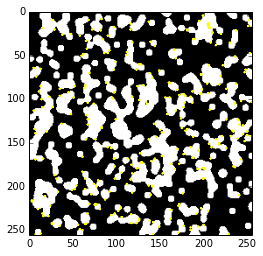

In [37]:
plt.imshow(result_gco, cmap='gray')
plt.contour(errors_gco, colors='yellow')

Using graph cuts, we have reduced the number of segmentation errors by a factor of 10! Not bad, huh? Most wrong pixels lie on domain boundaries, where it is more difficult to use information from neighboring pixels. 

Graph cuts is an awesome algorithm, that is both flexible, accurate and fast, with a lot of proven results about the accuracy of solutions. One downside is that the algorithm is a bit difficult to understand and to code. If you're just planning to use existing code, then the code of Boykov, that has a Matlab and a Python API (the latter by Andy Mueller) will just work great for you. 